# STAT41130 — PyTorch by Example (Weather & Climate Edition)

This notebook is a hands-on introduction to **PyTorch** using **real weather & climate datasets**.  
We start with tiny fully-connected neural nets (MLPs) to see training dynamics and convergence, then move to **1D and 2D Convolutional Neural Networks (CNNs)** with lightweight meteorological data.

**Datasets used (small and fetchable):**
- **Daily Minimum Temperatures (Sydney)** — a classic weather time series (CSV, small).  
- **Mauna Loa Atmospheric CO₂ (monthly means)** — canonical climate series (CSV/text, tiny).  
- **NARR reanalysis example** via **MetPy** test data — small NetCDF field we can treat like an image.

> Tip: GPU is nice but CPU is fine — all examples are intentionally small.

## 0) Setup

We install/import a minimal scientific stack. If you already have these installed, the install cells will quickly no-op.

In [2]:
# If running in a fresh environment, uncomment the following lines.
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install -q numpy pandas matplotlib scikit-learn xarray netCDF4 metpy requests tqdm

import math, os, io, sys, json, time, textwrap, random, pathlib, itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Optional: xarray + MetPy for the 2D meteorological field
import xarray as xr
try:
    from metpy.cbook import get_test_data
    import metpy  # noqa: F401
    METPY_OK = True
except Exception as e:
    METPY_OK = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
DEVICE

device(type='cuda')

### Helper plotting utilities

In [3]:
def plot_series(y, yhat=None, title="", start=None, end=None):
    # Plot a time series and optional predictions.
    plt.figure(figsize=(10,3))
    if start is None: start = 0
    if end is None: end = len(y)
    plt.plot(range(start, end), y[start:end], label="observed")
    if yhat is not None:
        plt.plot(range(start, start+len(yhat)), yhat, label="pred", linestyle="--")
    plt.title(title); plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.tight_layout(); plt.show()


def training_curve(train_losses, val_losses=None, title="Training curve"):
    plt.figure(figsize=(6,3))
    plt.plot(train_losses, label="train")
    if val_losses is not None:
        plt.plot(val_losses, label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()


def show_kernels_2d(weight_tensor, max_k=8):
    # Visualise learned 2D conv kernels (out_channels x in_channels x kH x kW).
    W = weight_tensor.detach().cpu().numpy()
    oc, ic, kh, kw = W.shape
    n = min(oc, max_k)
    cols = n
    plt.figure(figsize=(1.8*cols, 1.8))
    for i in range(n):
        plt.subplot(1, cols, i+1)
        plt.imshow(W[i,0], aspect='auto')
        plt.axis('off')
        plt.title(f"k{i}")
    plt.tight_layout(); plt.show()

---
## 1) Warm-up: Tensors, autograd, and a tiny linear regression

We begin with the most basic concepts: tensors, automatic differentiation, and a minimal gradient descent loop.

Learned params: [2.4915049076080322, -0.9908077120780945]


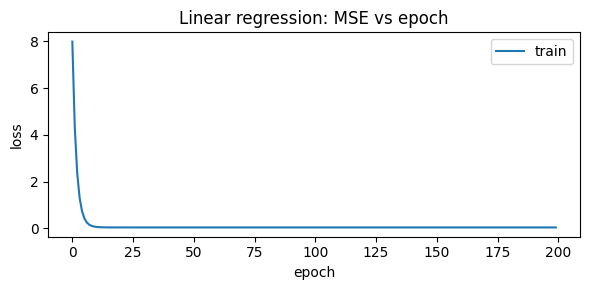

In [4]:
# Synthetic linear data: y = 2.5 * x - 1.0 + noise
n = 200
x = torch.linspace(-2, 2, n).unsqueeze(1)
true_w, true_b = 2.5, -1.0
y = true_w * x + true_b + 0.2 * torch.randn_like(x)

# Simple linear model
model = nn.Linear(1, 1)
opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

train_losses = []
for epoch in range(200):
    opt.zero_grad()
    yhat = model(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    opt.step()
    train_losses.append(loss.item())

print("Learned params:", [p.data.item() for p in model.parameters()])
training_curve(train_losses, title="Linear regression: MSE vs epoch")

**Takeaway:** PyTorch tracks operations on tensors, computes gradients via `.backward()`, and updates parameters with an optimizer.

---
## 2) Real data #1 — Daily Minimum Temperatures (Sydney)

**Task:** Given the previous 7 days, predict the next day's minimum temperature.

This is a small, classic weather time series. We’ll frame it as supervised learning with sliding windows.

In [5]:
import pandas as pd, requests

URL_TEMP = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(URL_TEMP, parse_dates=["Date"])
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [6]:
# Build supervised windows: X[t] = temps[t-7:t], y[t] = temp[t]
values = df["Temp"].values.astype(np.float32)
window = 7
X, Y = [], []
for t in range(window, len(values)):
    X.append(values[t-window:t])
    Y.append(values[t])
X = np.stack(X)   # (N, 7)
Y = np.array(Y)   # (N, )
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_s, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train,  dtype=torch.float32).unsqueeze(1).to(DEVICE)
X_test_t  = torch.tensor(X_test_s, dtype=torch.float32).to(DEVICE)
y_test_t  = torch.tensor(y_test,   dtype=torch.float32).unsqueeze(1).to(DEVICE)

len(X_train_t), len(X_test_t), X_train_t.shape

(2914, 729, torch.Size([2914, 7]))

### 2.1 A tiny MLP (fully-connected network)

Final val MSE: 13.727404594421387


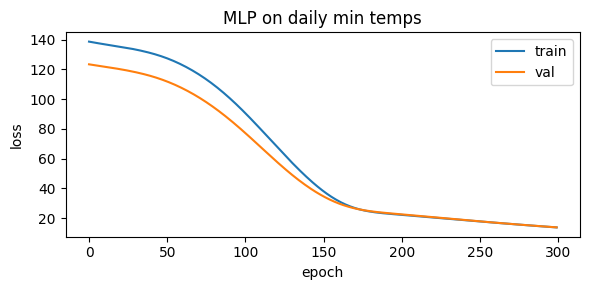

In [7]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
    def forward(self, x): return self.net(x)

mlp = MLP(in_dim=7).to(DEVICE)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses, val_losses = [], []
X_tr, X_val, y_tr, y_val = X_train_t[:-200], X_train_t[-200:], y_train_t[:-200], y_train_t[-200:]
for epoch in range(300):
    mlp.train()
    opt.zero_grad()
    yhat = mlp(X_tr)
    loss = loss_fn(yhat, y_tr)
    loss.backward(); opt.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val = loss_fn(mlp(X_val), y_val).item()
        val_losses.append(val)

print("Final val MSE:", val_losses[-1])
training_curve(train_losses, val_losses, title="MLP on daily min temps")

Test MSE: 11.638923645019531 R^2: 0.30939483642578125


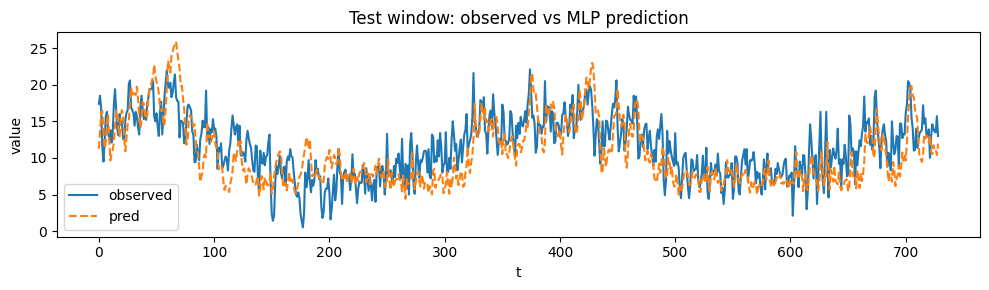

In [8]:
# Evaluate on held-out test
mlp.eval()
with torch.no_grad():
    pred = mlp(X_test_t).cpu().numpy().squeeze()
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print("Test MSE:", mse, "R^2:", r2)

plot_series(df["Temp"].values[-len(y_test):], yhat=pred, title="Test window: observed vs MLP prediction")

### 2.2 Dropout and BatchNorm demo

Test MSE: 5.645264148712158


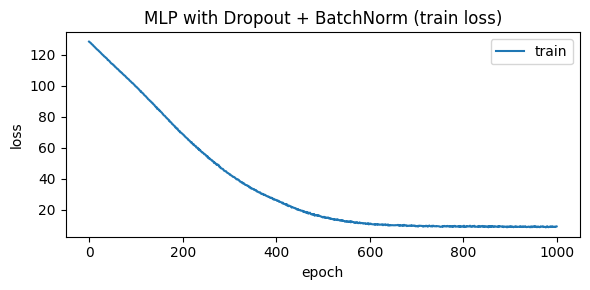

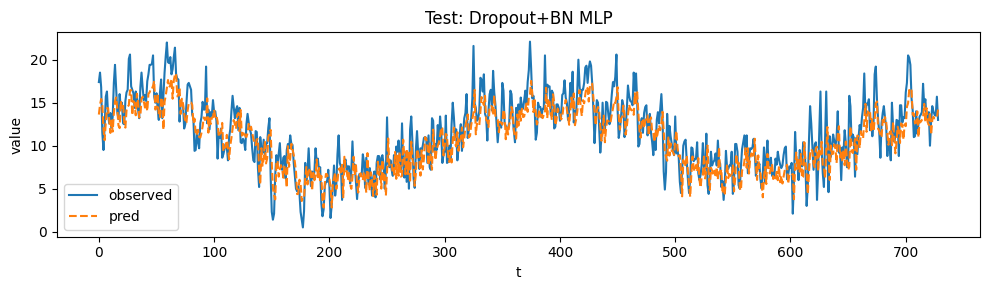

In [14]:
class MLP_DropBN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, 1)
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        return self.fc3(x)

mlp2 = MLP_DropBN(7).to(DEVICE)
opt = torch.optim.Adam(mlp2.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
train_losses = []
for epoch in range(1000):
    mlp2.train(); opt.zero_grad()
    loss = loss_fn(mlp2(X_train_t), y_train_t)
    loss.backward(); opt.step()
    train_losses.append(loss.item())

mlp2.eval()
with torch.no_grad():
    pred2 = mlp2(X_test_t).cpu().numpy().squeeze()
print("Test MSE:", mean_squared_error(y_test, pred2))
training_curve(train_losses, title="MLP with Dropout + BatchNorm (train loss)")
plot_series(df["Temp"].values[-len(y_test):], yhat=pred2, title="Test: Dropout+BN MLP")

---
## 3) Real data #2 — Mauna Loa CO₂ (monthly) with 1D CNN

In [10]:
# Fetch NOAA Mauna Loa monthly CO2 data (CSV or TXT)
import pandas as pd, io, requests, numpy as np

def load_maunaloa_monthly():
    urls = [
        "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv",
        "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv",
        "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.txt",
    ]
    for u in urls:
        try:
            r = requests.get(u, timeout=20)
            if r.ok:
                if u.endswith(".csv"):
                    df = pd.read_csv(io.StringIO(r.text), comment="#")
                    candidates = [c for c in df.columns if c.strip().lower() in ("average","interpolated","trend")]
                    if not candidates:
                        nums = df.select_dtypes(include=[np.number]).columns.tolist()
                        candidates = [nums[0]] if nums else []
                    df = df.rename(columns={candidates[0]: "co2"})
                    df = df.dropna(subset=["co2"]).reset_index(drop=True)
                    return df
                else:
                    lines = [ln for ln in r.text.splitlines() if not ln.strip().startswith("#")]
                    data = []
                    for ln in lines:
                        parts = ln.split(",")
                        if len(parts) >= 5:
                            try:
                                yr = int(parts[0]); mo = int(parts[1]); val = float(parts[4])
                                data.append((f"{yr}-{mo:02d}", val))
                            except:
                                pass
                    df = pd.DataFrame(data, columns=["date", "co2"])
                    return df
        except Exception:
            continue
    raise RuntimeError("Failed to download CO2 series")

co2 = load_maunaloa_monthly()
co2.head()

,year,month,decimal,co2,average_unc,trend,trend_unc
0,1979,1,1979.042,336.56,0.11,335.92,0.09
1,1979,2,1979.125,337.29,0.09,336.25,0.09
2,1979,3,1979.208,337.88,0.11,336.51,0.09
3,1979,4,1979.292,338.32,0.13,336.72,0.10
4,1979,5,1979.375,338.26,0.04,336.71,0.10


CO2 forecast — Test MSE: 3.5285518169403076 R^2: 0.9213708639144897


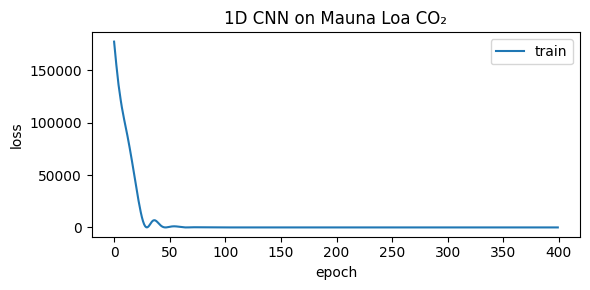

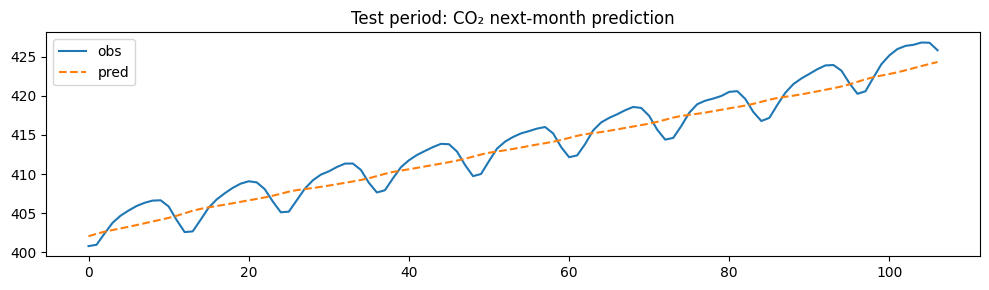

In [11]:
# Build 24-month windows for 1D CNN
vals = co2["co2"].values.astype(np.float32)
context = 24
X, Y = [], []
for t in range(context, len(vals)):
    X.append(vals[t-context:t])
    Y.append(vals[t])
X = np.array(X)[:, None, :]   # (N, C=1, L=context)
Y = np.array(Y)[:, None]      # (N, 1)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.2, shuffle=False)
X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
y_tr_t = torch.tensor(y_tr, dtype=torch.float32).to(DEVICE)
X_te_t = torch.tensor(X_te, dtype=torch.float32).to(DEVICE)
y_te_t = torch.tensor(y_te, dtype=torch.float32).to(DEVICE)

class TinyCNN1D(nn.Module):
    def __init__(self, in_ch=1, width=16, k=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, width, kernel_size=k, padding="same")
        self.conv2 = nn.Conv1d(width, width, kernel_size=k, padding="same")
        self.head  = nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(width, 1))
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.head(x)

model = TinyCNN1D().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=3e-3)
loss_fn = nn.MSELoss()

train_losses = []
for epoch in range(400):
    model.train(); opt.zero_grad()
    yhat = model(X_tr_t)
    loss = loss_fn(yhat, y_tr_t)
    loss.backward(); opt.step()
    train_losses.append(loss.item())

model.eval()
with torch.no_grad():
    pred = model(X_te_t).cpu().numpy().squeeze()
mse = mean_squared_error(y_te.squeeze(), pred)
r2  = r2_score(y_te.squeeze(), pred)
print("CO2 forecast — Test MSE:", mse, "R^2:", r2)
training_curve(train_losses, title="1D CNN on Mauna Loa CO₂")
plt.figure(figsize=(10,3))
plt.plot(y_te.squeeze(), label="obs")
plt.plot(pred, label="pred", linestyle="--")
plt.legend(); plt.title("Test period: CO₂ next-month prediction"); plt.tight_layout(); plt.show()

---
## 4) 2D CNN on a meteorological field (MetPy test data)

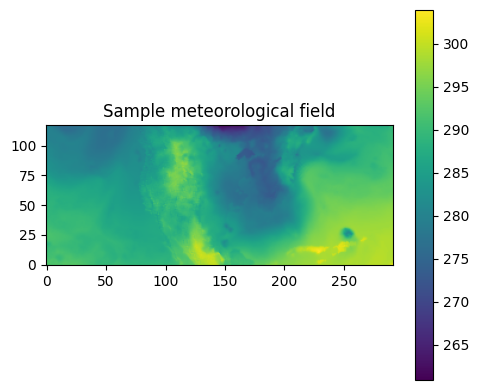

Patch classification accuracy: 0.542658154381892


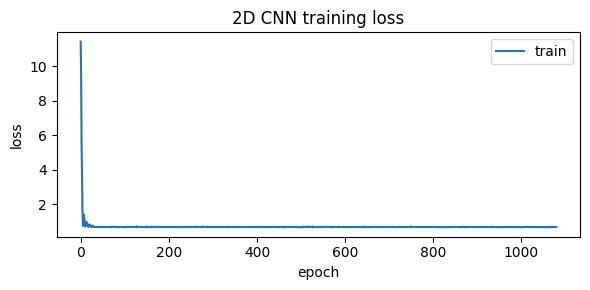

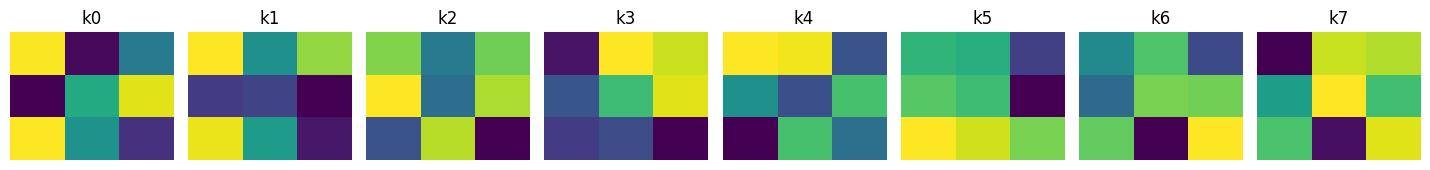

In [12]:
assert METPY_OK, "MetPy is required for the next section. Please install metpy and rerun the notebook."

ds = xr.open_dataset(get_test_data('narr_example.nc', as_file_obj=False))
# Select a single 2D field at one pressure level & time
if "Temperature" in ds:
    da = ds["Temperature"].isel(time=0, isobaric=0)  # (y, x)
else:
    chosen = None
    for name in ds.data_vars:
        if ds[name].ndim >= 2:
            chosen = ds[name]; break
    if chosen.ndim == 3:
        da = chosen.isel(time=0)
        if da.ndim == 3 and "isobaric" in da.dims:
            da = da.isel(isobaric=0)
    else:
        da = chosen

field = np.array(da.values, dtype=np.float32)
plt.figure(figsize=(5,4))
plt.imshow(field, origin="lower")
plt.colorbar(); plt.title("Sample meteorological field"); plt.tight_layout(); plt.show()

H, W = field.shape
mu = np.nanmean(field)
labels = (field > mu).astype(np.int64)  # 1 if above-mean, else 0

# Extract small patches for supervised classification
patch = 9  # 9x9 neighborhood
pad = patch//2
field_nan = np.nan_to_num(field, nan=float(mu))
Fpad = np.pad(field_nan, pad_width=pad, mode="reflect")

Xs, Ys = [], []
for i in range(pad, pad+H):
    for j in range(pad, pad+W):
        win = Fpad[i-pad:i+pad+1, j-pad:j+pad+1]
        Xs.append(win[None, ...])  # (1, patch, patch)
        Ys.append(labels[i-pad, j-pad])
Xs = np.stack(Xs).astype(np.float32)
Ys = np.array(Ys).astype(np.int64)

# Train/test split
N = len(Ys)
idx = np.arange(N); np.random.shuffle(idx)
train_n = int(0.8*N)
tr_idx, te_idx = idx[:train_n], idx[train_n:]
X_tr, X_te = Xs[tr_idx], Xs[te_idx]
y_tr, y_te = Ys[tr_idx], Ys[te_idx]

X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
y_tr_t = torch.tensor(y_tr, dtype=torch.long).to(DEVICE)
X_te_t = torch.tensor(X_te, dtype=torch.float32).to(DEVICE)
y_te_t = torch.tensor(y_te, dtype=torch.long).to(DEVICE)

class TinyCNN2D(nn.Module):
    def __init__(self, in_ch=1, k=3, c=8):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, c, kernel_size=k, padding=1),
            nn.ReLU(),
            nn.Conv2d(c, c, kernel_size=k, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(c, 2*c, kernel_size=k, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Linear(2*c, 2)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

net = TinyCNN2D().to(DEVICE)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

batch = 256
train_losses = []
for epoch in range(10):  # quick
    net.train()
    perm = torch.randperm(X_tr_t.size(0))
    for i in range(0, X_tr_t.size(0), batch):
        ix = perm[i:i+batch]
        xb, yb = X_tr_t[ix], y_tr_t[ix]
        opt.zero_grad()
        logits = net(xb)
        loss = criterion(logits, yb)
        loss.backward(); opt.step()
        train_losses.append(loss.item())

net.eval()
with torch.no_grad():
    logits = net(X_te_t)
    pred = logits.argmax(1).cpu().numpy()
    acc = (pred == y_te).mean()
print("Patch classification accuracy:", acc)
training_curve(train_losses, title="2D CNN training loss")
show_kernels_2d(net.features[0].weight, max_k=8)

---
## 5) PyTorch training patterns: DataLoader, early stopping, schedulers, saving

Early stopping at epoch 100


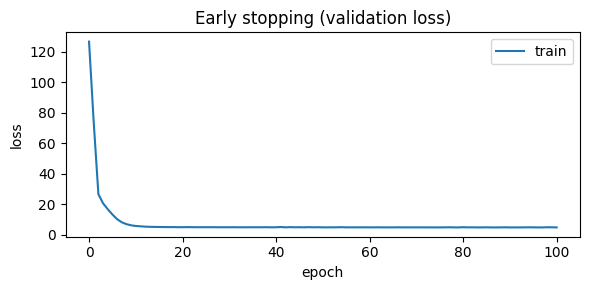

Best val: 4.87534761428833


In [13]:
class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# Reuse temperature dataset
from sklearn.model_selection import train_test_split
ds = WindowDataset(X_train_s, y_train)
dl = DataLoader(ds, batch_size=64, shuffle=True)

model = MLP(7).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_loss = float("inf"); patience, wait = 10, 0
history = []
for epoch in range(200):
    model.train()
    for xb, yb in dl:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward(); opt.step()
    # simple val check
    model.eval()
    with torch.no_grad():
        val = loss_fn(model(torch.tensor(X_test_s, dtype=torch.float32).to(DEVICE)),
                      torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)).item()
    history.append(val)
    if val < best_loss - 1e-4:
        best_loss, wait = val, 0
        torch.save(model.state_dict(), "best_mlp.pt")
    else:
        wait += 1
    if wait >= patience:
        print("Early stopping at epoch", epoch)
        break

training_curve(history, title="Early stopping (validation loss)")
print("Best val:", best_loss)

---
## 6) Next steps
- Compare MLP vs 1D CNN on the same sequence.
- Turn the 2D toy task into a real prediction with past-time inputs.
- Try BatchNorm2d, Dropout2d, and weight decay for generalization.
- Explore some of the exampels on MetPy some more and see what else you can find. 